In [33]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [34]:
np.random.seed(11)
torch.manual_seed(11)

In [35]:
def create_graph(n_nodes=10):
    W = np.random.rand(n_nodes, n_nodes)
    W = (W + W.T) / 2
    W = W * (np.random.rand(n_nodes, n_nodes) > 0.5)
    np.fill_diagonal(W, 0)
    return W

In [36]:
def compute_laplacian(W):
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    return L

In [37]:
def generate_dataset(n_graphs=100, n_nodes=10):
    graphs = []
    signals = []
    labels = []
    
    for _ in range(n_graphs):
        # グラフの生成
        W = create_graph(n_nodes)
        L = compute_laplacian(W)
        
        # 固有値分解
        eigenvalues, eigenvectors = eigsh(sparse.csr_matrix(L), k=n_nodes-1, which='SM')
        
        # 滑らかな信号（低周波成分のみで構成）
        coeffs = np.random.randn(eigenvalues.shape[0]) * np.exp(-eigenvalues)  # 低周波を強調
        smooth_signal = eigenvectors @ coeffs
        # ノイズを追加した入力信号
        noisy_signal = smooth_signal + 0.5 * np.random.randn(n_nodes)
        
        graphs.append((W, L, eigenvectors, eigenvalues))
        signals.append(noisy_signal)
        labels.append(smooth_signal)
    
    return graphs, np.array(signals), np.array(labels)

In [38]:
class SpectralConv(nn.Module):
    def __init__(self, n_nodes, n_in_channels, n_out_channels):
        super(SpectralConv, self).__init__()
        self.n_nodes = n_nodes
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        # フィルタのパラメータ（各固有値に対するスケーリング）
        self.filter_params = nn.Parameter(
            torch.randn(n_nodes-1, n_in_channels, n_out_channels) * 0.01
        )
        self.relu = nn.ReLU()

    def forward(self, signal, eigenvectors, eigenvalues):
        # signal: (n_nodes, n_in_channels)
        # eigenvectors: (n_nodes, n_nodes-1)
        # eigenvalues: (n_nodes-1,)
        
        # フーリエ変換: f_hat = U^T * signal
        f_hat = torch.matmul(torch.tensor(eigenvectors.T, dtype=torch.float32), 
                           torch.tensor(signal, dtype=torch.float32))  # (n_nodes-1, n_in_channels)
        
        # フィルタリング: f_hat_filtered = g(\Lambda) * f_hat
        f_hat_filtered = torch.zeros((self.n_nodes-1, self.n_out_channels))
        for j in range(self.n_out_channels):
            for i in range(self.n_in_channels):
                f_hat_filtered[:, j] += f_hat[:, i] * self.filter_params[:, i, j]
        
        # 逆フーリエ変換: f_new = U * f_hat_filtered
        f_new = torch.matmul(torch.tensor(eigenvectors, dtype=torch.float32), f_hat_filtered)
        
        # 非線形性の適用
        f_new = self.relu(f_new)
        return f_new

In [39]:
class SpectralNet(nn.Module):
    def __init__(self, n_nodes, n_in_channels, n_hidden_channels, n_out_channels):
        super(SpectralNet, self).__init__()
        self.conv1 = SpectralConv(n_nodes, n_in_channels, n_hidden_channels)
        self.conv2 = SpectralConv(n_nodes, n_hidden_channels, n_out_channels)
    
    def forward(self, signal, eigenvectors, eigenvalues):
        x = self.conv1(signal, eigenvectors, eigenvalues)
        x = self.conv2(x, eigenvectors, eigenvalues)
        return x

In [40]:
def train_model(n_epochs=100):
    graphs, signals, labels = generate_dataset(n_graphs=100, n_nodes=10)
    model = SpectralNet(n_nodes=10, n_in_channels=1, n_hidden_channels=4, n_out_channels=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    losses = []
    
    for epoch in range(n_epochs):
        total_loss = 0
        for i in range(len(graphs)):
            W, L, U, Lambda = graphs[i]
            signal = signals[i][:, np.newaxis]
            label = labels[i][:, np.newaxis]
            signal = torch.tensor(signal, dtype=torch.float32)
            label = torch.tensor(label, dtype=torch.float32)
            output = model(signal, U, Lambda)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(graphs)
        losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}")
    
    return model, losses

In [41]:
def evaluate_model(model):
    graphs, signals, labels = generate_dataset(n_graphs=1, n_nodes=10)
    W, L, U, Lambda = graphs[0]
    signal = signals[0][:, np.newaxis]
    label = labels[0][:, np.newaxis]
    
    model.eval()
    with torch.no_grad():
        signal_tensor = torch.tensor(signal, dtype=torch.float32)
        output = model(signal_tensor, U, Lambda)
    
    # プロット
    plt.figure(figsize=(10, 5))
    plt.plot(signal, label='Input (Noisy)', marker='o')
    plt.plot(label, label='Ground Truth (Smooth)', marker='o')
    plt.plot(output.numpy(), label='Predicted (Smooth)', marker='o')
    plt.legend()
    plt.title("Signal Prediction")
    plt.show()

/tmp/ipykernel_30593/3886909566.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(signal, dtype=torch.float32))  # (n_nodes-1, n_in_channels)


Epoch 10/100, Loss: 0.145956
Epoch 20/100, Loss: 0.139592
Epoch 30/100, Loss: 0.134028
Epoch 40/100, Loss: 0.129128
Epoch 50/100, Loss: 0.124831
Epoch 60/100, Loss: 0.121047
Epoch 70/100, Loss: 0.117703
Epoch 80/100, Loss: 0.114744
Epoch 90/100, Loss: 0.112131
Epoch 100/100, Loss: 0.109819


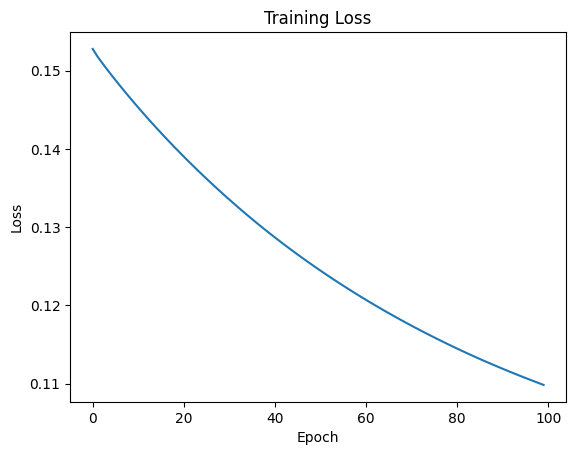

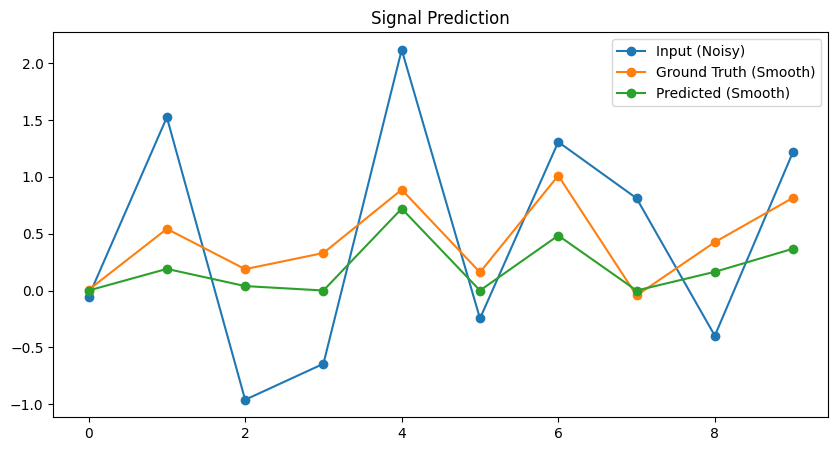

In [42]:
model, losses = train_model(n_epochs=100)
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()
evaluate_model(model)